# Call takeaway:

1. Pre-filtr Households - simulace davky mimoradne pomoci etc.
2. Možnost zastropování výdajů? 
3. Kouknout na Prokopa ještě tento týden
4. Rozělit YEARS_OF_SUPPORT na private vs municipal
5. Potřebuji vůbec active vs inactive hhs? 


## Definitions

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pdb
idx = pd.IndexSlice

### Default parameters

použití parametrů viz níže

In [3]:
default_params = {
    'years':np.arange(40),
    'municipal_years_of_support':5,
    'private_years_of_support':2,
    'apartment_cost':25000, # 24000+7200 dle https://docs.google.com/document/d/1JAMspnkjakIaFpYuhAtch7sMhC5xd3dA/edit?usp=sharing&ouid=106125284349865545127&rtpof=true&sd=true 
    'private_yearly_apartments':5000, # Konzervativní odhad 2500 - 1 byt na měsíc pro každé ORP; Divoký odhad 10 000 bytl,
    'municipal_apartments_today': 200000,
    'municipal_yearly_new_apartments': 1000,
    'municipal_existing_availability_rate': .015,
    'municipal_new_availability_rate': .5,
    'active_current_hh_in_need':43250,
    'active_yearly_new_hh':2000,
    'inactive_current_hh_in_need':60000,
    'inactive_yearly_new_hh':500,
    'relapse_rate':.3, # share of supported clients returning to the system later
    'returnee_delay':1 # years after failed returnees enter the system again
}

 ## Nabídka - byty v systému

* Nabídka simuluje počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. Model simuluje zvlášť byty ze soukromého sektoru a byty, které jsou ve správě místních samospráv
* Nastavení modelu vede k  (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 5000 soukromých a pomalu rostoucích cca 3500 - 4000 městských bytů v systému ročně.

### Soukromé byty
* Nabídka soukromých bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `private_yearly_apartments`.
* Z komunikace s Romanem Matouškem proto vzešel návrh zvažovat tři scénáře: 
    - *Konzervativní* - 2 500 bytů ročně, tj. 10 bytů na ORP, tedy méně než 1 byt na ORP za měsíc
    - *Střední* - 5 000 bytů ročně
    - *Rozsáhlý* - 10 000 bytů ročně
* Pokud není řečeno jinak je použit *střední scénář* 

### Obecní byty
* Již dnes existuje cca 200 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 1,5 % uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - konzervativně předpokládáme 1000 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému výrazně větší část - klidně 50 % - `municipal_new_availability_rate`


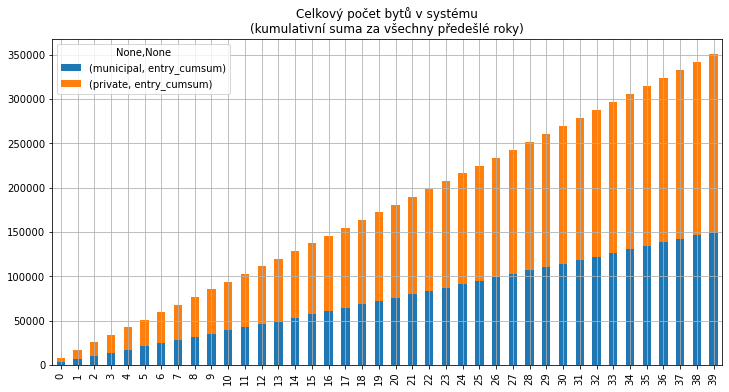

In [49]:
from supply import simulate_apartment_stock

apartments = simulate_apartment_stock(
    private_yearly_apartments=default_params['private_yearly_apartments'],
    municipal_apartments_today=default_params['municipal_apartments_today'],
    municipal_yearly_new_apartments=default_params['municipal_yearly_new_apartments'],
    municipal_existing_availability_rate=default_params['municipal_existing_availability_rate'],
    municipal_new_availability_rate=default_params['municipal_new_availability_rate'],
    years=default_params['years']
)
apartments.plot.bar(stacked=True, title='Celkový počet bytů v systému\n(kumulativní suma za všechny předešlé roky)',figsize=(12,6),grid=True);

## Poptávka - lidé v bytové nouzi

* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje *ekonomicky aktivní* domácnosti do *soukromých* bytů a *ekonomicky neaktivní* domácnosti do *obecních* bytů 
* Oba druhy domácností mají v čase lineární trend

### Ekonomicky aktivní 

* Dnešní počet ekonomicky aktivních domácností v bytové nouzi je 43 250 - `active_current_hh_in_need`. Vychází ze Zprávy o vyloučení z bydlení 2021
* Předpokládáme každoroční propad dalších 2000 domácností do bytové nouze -  `active_yearly_new_hh`.

### Ekonomicky neaktivní
* Dnešní počet ekonomicky aktivních domácností v bytové nouzi je 60 000 - `inactive_current_hh_in_need`. Myslím, že na radu Romana Matouška.
* Předpokládáme každoroční propad dalších 500 domácností do bytové nouze -  `inactive_yearly_new_hh`.

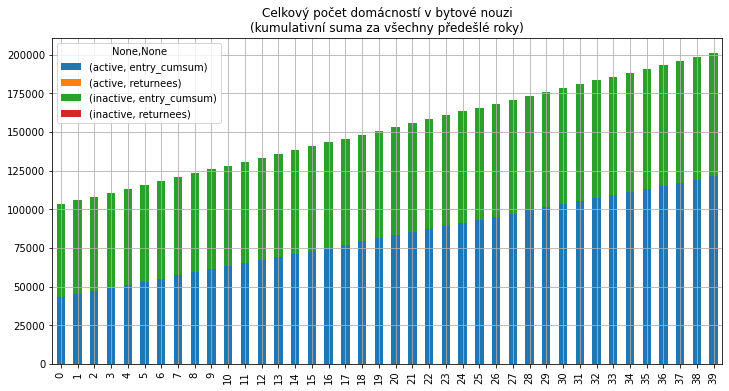

In [58]:
from demand import simulate_hh_stock

hhs = simulate_hh_stock(
    active_current_hh_in_need = default_params['active_current_hh_in_need'],
    active_yearly_new_hh = default_params['active_yearly_new_hh'],
    inactive_current_hh_in_need = default_params['inactive_current_hh_in_need'],
    inactive_yearly_new_hh = default_params['inactive_yearly_new_hh'],
    years = default_params['years']
)
hhs.plot.bar(stacked=True, grid=True, title='Celkový počet domácností v bytové nouzi\n(kumulativní suma za všechny předešlé roky)', figsize=(12,6));

## Přiřazování domácností do bytů
* Přiřazování probíhá v následujícím pořadí, přičemž první dva body se vzájemně neruší
    1. Ekonomicky aktivní do soukromých bytů 
    2. Ekonomicky nekativní do obecních bytů
    3. Ekonomicky neaktivní do soukromých bytů
    4. Ekonomicky aktivní do obecních bytů

* Určitá část domácností (`relapse_rate`) se po čase (`returnee_delay` - v letech) se opět vrací do systému jako "nové" domácnosti
* Model ukazuje, že ze začátku je hlavním limitem počet dostupných bytů - vždy se všechny využijí. V tomto nastavení modelu prvních cca 25 let. Poté se systém vyčerpá

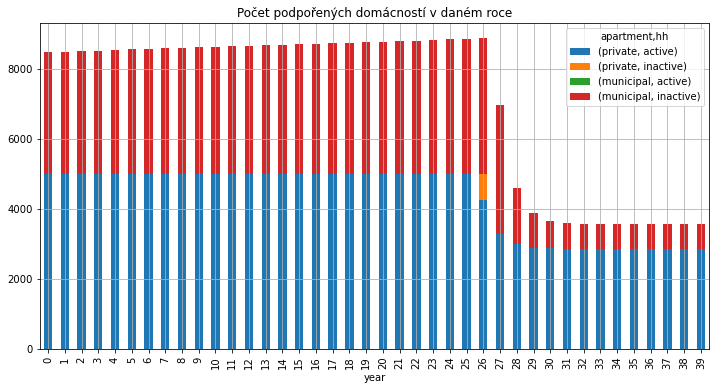

In [51]:
from clearing import generate_flows

flows = generate_flows(
    apartments=apartments,
    hhs=hhs, 
    relapse_rate=default_params['relapse_rate'],
    returnee_delay=default_params['returnee_delay'],
    years=default_params['years']
)
flows.unstack(['apartment','hh']).plot.bar(stacked=True, grid=True, figsize=(12,6),title='Počet podpořených domácností v daném roce');

### Celková simulace
* Posledními parametry jsou


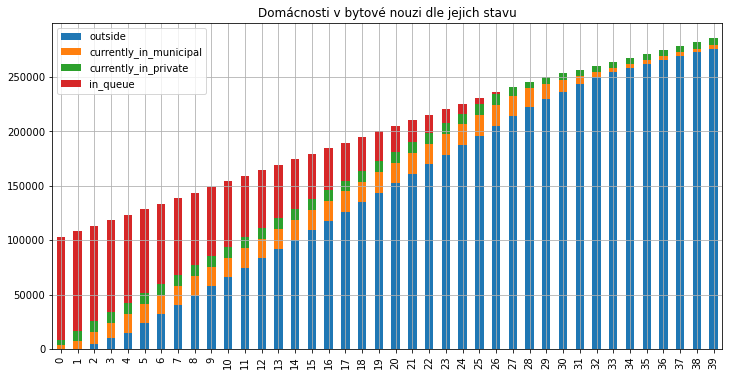

In [59]:
from main import simulate_social_housing
flows,hhs_stats = simulate_social_housing(**default_params)

hhs_stats.stack(1).sum(axis=1).unstack()[['outside','currently_in_municipal','currently_in_private','in_queue']].plot.bar(stacked=True,figsize=(12,6),title='Domácnosti v bytové nouzi dle jejich stavu',grid=True);

In [ ]:
pd.DataFrame({
    ('active','newcomers_cumsum'):[],
    ('active','returnees_cumsum'):[],
    ('active','total_cumsum'):[]
})

In [ ]:
hhs.loc[:,[('active','entry_cumsum'),('inactive','entry_cumsum')]]

In [ ]:
hhs = hhs.join(hhs.loc[:,idx[:,'entry_cumsum']].diff().rename(mapper=lambda col: col.replace('entry_cumsum','new_entry'),axis=1))
hhs.sort_index(axis=1)

In [ ]:
hhs.loc[:,idx[:,'entry_cumsum']].plot.bar(stacked=True)

In [ ]:
fig, axs= plt.subplots(nrows=2,ncols=2,figsize=(20,12))

flows.unstack(['hh','apartment']).plot.bar(stacked=True,ax=axs[0,0],title='Počet umístěných do bytů')
axs[0,1].set_title('Počet domácností v bytové nouzi dle ekonomické aktivity \n a stavu v systému (Umístěn do soukromého/městského/returnee)')
axs[1,0].set_title('Počet bytů v systému dle stavu')


fig.tight_layout()

## Get exits, currently_actives and costs

In [ ]:
def plot_number_hh(df,ax=None):
    plotdf = df[[("private","entry_cumsum"),("municipal","cumsum")]]
    plotdf.columns = ["Soukromé byty", "Obecní byty"]
    title = f"Počet domácností \n Celkem: {round(plotdf.sum().sum())} domácností \n Soukromé byty: {plotdf['Soukromé byty'].sum()} domácností; Obecní byty: {round(plotdf['Obecní byty'].sum())} domácností "
    ax = plotdf.plot.bar(stacked=True, title = title, ax= ax)

    return ax

def plot_yearly_costs(df,ax=None):
    plotdf = df[[("private","cost"),("municipal","cost")]]
    plotdf.columns = ["Soukromé byty", "Obecní byty"]
    title = f"Odhadované náklady \n Celkem: {round(plotdf.sum().sum()/1000000)} mil. Kč \n Soukromé byty: {round(plotdf['Soukromé byty'].sum()/1000000)} mil. Kč; Obecní byty: {round(plotdf['Obecní byty'].sum()/1000000)} mil. Kč "
    ax = plotdf.plot.bar(stacked=True, title = title, ax=ax)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{round(x/1000000)} mil. Kč" ))

    return ax

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
axs[0] = plot_number_hh(cleared, axs[0])
axs[1] = plot_yearly_costs(cleared, axs[1])
fig.suptitle('Počet domácností a odhadované náklady systému garancí pro sociální bydlení')
fig.tight_layout()

### Průměrné roční náklady na garanční schéma

In [ ]:
import seaborn as sns

ax = sns.heatmap(
    (pd.Series({
        (priv_aps, new_muni) :simulate_private_municipal(private_yearly_apartments=priv_aps, municipal_yearly_new_apartments=new_muni).both.cost.sum()/SIMULATE_YEARS
        for priv_aps in [2500,5000,10000]
        for new_muni in [1000,2000,5000]
    }).unstack(1)/1000000).astype(int),annot=True, fmt='d',cmap='Reds',cbar=False,linewidths=1
)
ax.set_ylabel('Počet nových soukromých bytů ročně')
ax.set_xlabel('Počet nových obecních bytů ročně')
ax.set_title('Odhadované náklady v závislosti  \n na absorpčních kapacitách systému (mil. Kč)');

In [ ]:
col_order = [
    ('apartments', 'private', 'total'),
    ('apartments', 'private', 'assigned'),
    ('apartments', 'private', 'available'),
    ('hhs', 'active', 'total'),
    ('hhs', 'active', 'intervened'),
    ('hhs', 'active', 'need_intervention'),
    ('apartments', 'municipal', 'total'),
    ('apartments', 'municipal', 'assigned'),
    ('apartments', 'municipal', 'available'),
    ('hhs', 'inactive', 'total'),
    ('hhs', 'inactive', 'intervened'),
    ('hhs', 'inactive', 'need_intervention')
]

cleared#.loc[:,idx[:,['private','active']]]